In [ ]:
%%capture
!pip install timm
!pip install pytorch_msssim

In [ ]:
import torch as T
import random
from torch.nn import functional as F
from torch import nn
import cv2
from PIL import Image, ImageOps, ImageEnhance, __version__ as PILLOW_VERSION
import matplotlib.pyplot as plt
import timm
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, SequentialSampler
from torchvision import transforms
import torchvision
import torchvision.transforms.functional as tvf
import numpy as np
import os
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
import time
import math
from prettytable import PrettyTable
import pandas as pd
from ast import literal_eval
from tqdm import tqdm
from matplotlib import pyplot as plt

device = "cuda" if T.cuda.is_available() else "cpu"

In [ ]:
class Encoder(nn.Module):
    def __init__(self, backbone = 'resnet18', device = 'cuda'):
        super(Encoder, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained = True)
        self.List = list(self.backbone.children())[:-2]
        self.device = device
    def forward(self,X):
        X = X.to(self.device).float()
        outputs = []
        for i,layer in enumerate(self.List):
            X = layer(X)
            if i > 1:
                outputs.append(X)
        return outputs

class ResidualLayer(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels):
        super(ResidualLayer, self).__init__()
        self.resblock = nn.Sequential(nn.Conv2d(in_channels, out_channels,
                                                kernel_size=3, padding=1, bias=False),
                                      nn.ReLU(True),
                                      nn.Conv2d(out_channels, out_channels,
                                                kernel_size=1, bias=False))
        self.conv = nn.Conv2d(in_channels*2, out_channels,
                                                kernel_size=3, padding=1, bias=False)

    def forward(self, input_1,input_2):
        Y = input_1 + self.resblock(input_1)
        Y = T.cat((Y,input_2),dim=1)
        return self.conv(Y)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode = 'bilinear')
        self.res1 = ResidualLayer(256,256)
        self.res2 = ResidualLayer(128,128)
        self.res3 = ResidualLayer(64,64)
        self.res4 = ResidualLayer(64,64)
        self.conv1 = nn.Conv2d(512,256,(3,3),padding = 1)  
        self.conv2 = nn.Conv2d(256,128,(3,3),padding = 1)  
        self.conv3 = nn.Conv2d(128,64,(3,3),padding = 1)
        self.conv4 = nn.Conv2d(64,64,(3,3),padding = 1)
        self.out = nn.Conv2d(64,3,(1,1))
        self.sigmoid = nn.Sigmoid()
        
    def forward(self,outputs):
        X = self.upsample(outputs[-1])
        X = F.relu(self.conv1(X))
        X = self.res1(X,outputs[-2])
        X = self.upsample(X)
        X = F.relu(self.conv2(X))
        X = self.res2(X,outputs[-3])
        X = self.upsample(X)
        X = F.relu(self.conv3(X))
        X = self.res3(X,outputs[-5])
        X = self.upsample(X)
        X = F.relu(self.conv4(X))
        X = self.res4(X,outputs[-6])
        return self.out(X)
    
class DAE_UNet(nn.Module):
    def __init__(self,device='cuda'):
        super(DAE_UNet,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.to(device)
        
    def forward(self,X):
        X = self.encoder(X)
        X = self.decoder(X)
        return X

In [ ]:
class Data(Dataset):
    def __init__(self, dir_="../input/ai-club-inductions-21-image-enhancement/", input_size=(224,224), output_size=(112, 112),training = True):
        super().__init__()
        self.training = training
        self.directory = dir_
        if self.training:
            self.raw_files = sorted(os.listdir(self.directory+str("raw")))[30:]
        else:
            self.raw_files = sorted(os.listdir(self.directory+str("raw")))[:30]
        self.input_size = input_size
        self.output_size = output_size
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    def __len__(self): return len(self.raw_files)
    
    def __getitem_internal__(self, idx, preprocess=True):
        raw_path = self.directory+str("raw/")+self.raw_files[idx]
        enhanced_path = self.directory+str("enhanced/")+self.raw_files[idx]
        raw_image = cv2.imread(raw_path)
        enhanced_image = cv2.imread(enhanced_path)
        raw_image = cv2.resize(raw_image,self.input_size)
        enhanced_image = cv2.resize(enhanced_image,self.output_size)
        enhanced_image = transforms.ToTensor()(np.array(enhanced_image))
        if preprocess:
            raw_image = self.preprocess(np.array(raw_image))
        else:
            raw_image = transforms.ToTensor()(np.array(raw_image))
        return (raw_image,enhanced_image)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

In [ ]:
train_dataloader = Data()
print("Train :",train_dataloader.__len__())
val_dataloader = Data(training=False)
print("Val :",val_dataloader.__len__())

Train : 800
Val : 30


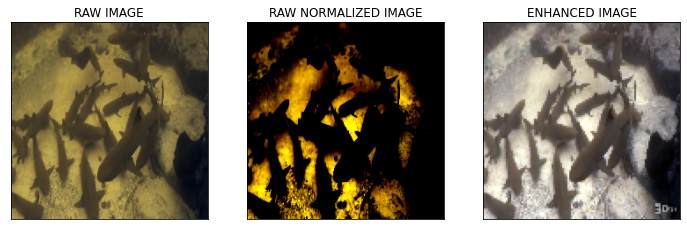

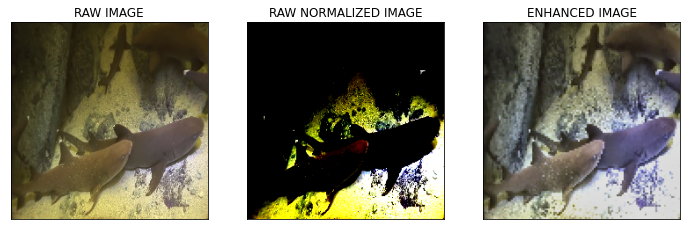

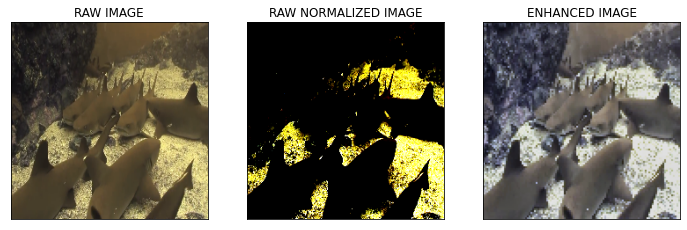

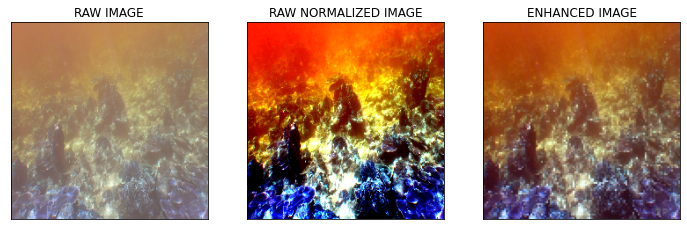

In [ ]:
for i in range(5,9):
    raw_normalized, enhanced = train_dataloader[i]
    raw,_ = train_dataloader.raw(i)
    fig, ax = plt.subplots(1, 3,figsize=(12,4))
    ax[0].imshow(raw.permute(1,2,0).numpy())        
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].title.set_text('RAW IMAGE')
    ax[1].imshow(raw_normalized.permute(1,2,0).numpy())        
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].title.set_text('RAW NORMALIZED IMAGE')
    ax[2].imshow(enhanced.permute(1,2,0).numpy())        
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].title.set_text('ENHANCED IMAGE')
    plt.show()

In [ ]:
class VGGPerceptualLoss(T.nn.Module):
    def __init__(self, resize=True):
        super(VGGPerceptualLoss, self).__init__()
        blocks = []
        blocks.append(torchvision.models.vgg16(pretrained=True).features[:2].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[2:4].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[4:9].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[9:16].eval())
        blocks.append(torchvision.models.vgg16(pretrained=True).features[16:23].eval())
        for bl in blocks:
            for p in bl.parameters():
                p.requires_grad = False
            
        self.blocks = T.nn.ModuleList(blocks)
        self.transform = T.nn.functional.interpolate
        self.mean = T.nn.Parameter(T.tensor([0.485, 0.456, 0.406], device='cuda').view(1,3,1,1))
        self.std = T.nn.Parameter(T.tensor([0.229, 0.224, 0.225], device='cuda').view(1,3,1,1))
        self.resize = resize

    def forward(self, input, target):
        if input.shape[1] != 3:
            input = input.repeat(1, 3, 1, 1)
            target = target.repeat(1, 3, 1, 1)
        input = (input-self.mean) / self.std
        target = (target-self.mean) / self.std
        if self.resize:
            input = self.transform(input, mode='bilinear', size=(224, 224), align_corners=False)
            target = self.transform(target, mode='bilinear', size=(224, 224), align_corners=False)
        loss = 0.0
        x = input
        y = target
        for block in self.blocks:
            x = block(x)
            y = block(y)
            loss += T.nn.functional.l1_loss(x, y)
        return loss
    
model = DAE_UNet()
criterion1 = nn.MSELoss()
perceptual_loss = VGGPerceptualLoss().to(device)
ssim = SSIM(data_range=255, size_average=True, channel=3)

def loss_fn(predicted,target):
    return perceptual_loss(predicted,target)        #+1 - ssim(predicted,target)

@T.no_grad()
def validation(model, loader, loss_fn):
    vlosses = []
    v = tqdm(loader)
    model.eval()
    for i,(input_image,gt_image) in enumerate(v):
        input_image,gt_image = input_image.to(device), gt_image.to(device)
        y_pred = model(input_image)
        vloss = loss_fn(y_pred,gt_image)
        vlosses.append(vloss.item())
    j = random.randint(0,29)
    raw_normalized, enhanced = train_dataloader[j]
    raw,_ = train_dataloader.raw(j)
    y_pred = model(raw_normalized.unsqueeze(dim=0))
    fig, ax = plt.subplots(1, 3,figsize=(12,4))
    ax[0].imshow(raw.cpu().permute(1,2,0).numpy())        
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].title.set_text('INPUT IMAGE')
    ax[1].imshow(y_pred[0].cpu().permute(1,2,0).numpy())        
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].title.set_text('PREDICTED IMAGE')
    ax[2].imshow(enhanced.cpu().permute(1,2,0).numpy())        
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].title.set_text('GT IMAGE')
    plt.show()
    model.train()
    return np.array(vlosses).mean()

model.load_state_dict(T.load("./model.pth", map_location=device))
optimizer = T.optim.Adam(model.parameters(), lr=0.0001)

scheduler = T.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=0.5,patience=1,verbose=True)

In [ ]:
batch_size = 50
EPOCHES = 5

train_loader = DataLoader(train_dataloader,batch_size=batch_size,shuffle=False, num_workers=0, sampler=SubsetRandomSampler(list(range(len(train_dataloader)))),
                             drop_last=False)
val_loader = DataLoader(val_dataloader,batch_size=batch_size,shuffle=False,
                              num_workers=0,
                              sampler=SubsetRandomSampler(list(range(len(val_dataloader)))),
                             drop_last=False)
best_loss = None
raw_line0 = r'''Epoch[{}]    |    Lr:{}'''
raw_line1 = r'''TOTAL Train loss: {}  |  TOTAL Val loss: {}  |  Time:{:.1f} min '''

100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


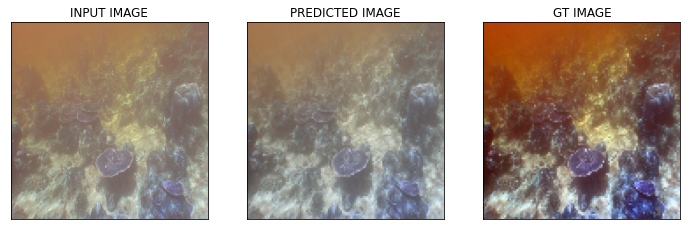

Epoch[1]    |    Lr:0.0001
TOTAL Train loss: 1.7458662316203117  |  TOTAL Val loss: 1.6343162059783936  |  Time:0.9 min 
saving model ..


100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


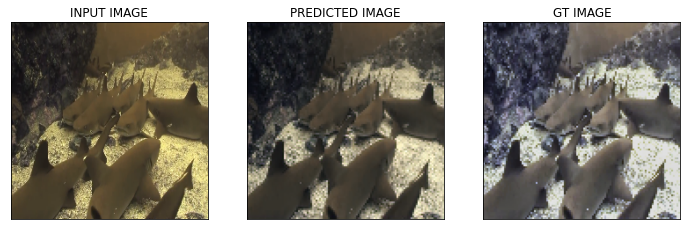

Epoch[2]    |    Lr:0.0001
TOTAL Train loss: 1.741093747317791  |  TOTAL Val loss: 1.634964942932129  |  Time:0.9 min 


100%|██████████| 1/1 [00:01<00:00,  1.49s/it]


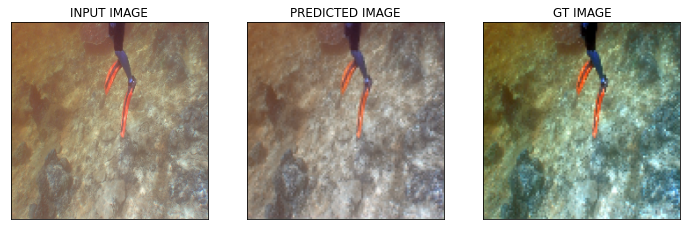

Epoch[3]    |    Lr:0.0001
TOTAL Train loss: 1.7394107729196548  |  TOTAL Val loss: 1.6421351432800293  |  Time:0.9 min 
Epoch     3: reducing learning rate of group 0 to 5.0000e-05.


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


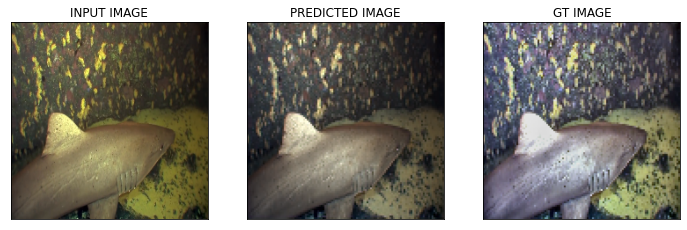

Epoch[4]    |    Lr:5e-05
TOTAL Train loss: 1.742191344499588  |  TOTAL Val loss: 1.6378449201583862  |  Time:0.9 min 


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


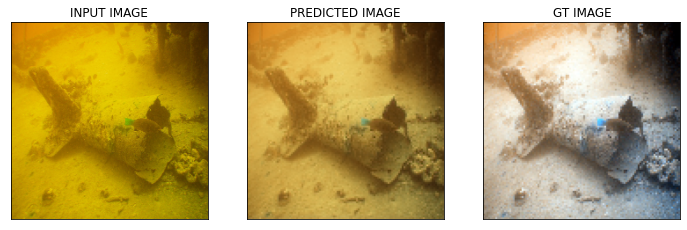

Epoch[5]    |    Lr:5e-05
TOTAL Train loss: 1.7410075664520264  |  TOTAL Val loss: 1.6401768922805786  |  Time:0.9 min 
Epoch     5: reducing learning rate of group 0 to 2.5000e-05.


In [ ]:
for epoch in range(1, EPOCHES+1):
        losses = []
        start_time = time.time()
        t = tqdm(train_loader)
        model.train()
        for i,(input_image,gt_image) in enumerate(t):
            input_image,gt_image = input_image.to(device), gt_image.to(device)
            optimizer.zero_grad()
            y_pred = model(input_image)
            loss = loss_fn(y_pred,gt_image)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        vloss = validation(model, val_loader, loss_fn)
        print(raw_line0.format(epoch,optimizer.param_groups[0]["lr"]))
        print(raw_line1.format(np.array(losses).mean(),vloss,(time.time()-start_time)/60**1))

        if best_loss == None:
            best_loss = vloss
            T.save(model.state_dict(), 'model.pth')
            print("saving model ..")
        if vloss < best_loss:
            best_loss = vloss
            T.save(model.state_dict(), 'model.pth')
            print("saving model ..")
        scheduler.step(vloss)

In [ ]:
class TestData(Dataset):
    def __init__(self, dir_="../input/ai-club-inductions-21-image-enhancement/", input_size=(224,224), output_size=(112, 112)):
        super().__init__()
        self.directory = dir_
        self.raw_files = os.listdir(self.directory+str("test"))
        self.input_size = input_size
        self.output_size = output_size
        self.preprocess = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


    def __len__(self): return len(self.raw_files)
    
    def __getitem_internal__(self, idx, preprocess=True):
        raw_path = self.directory+str("test/")+self.raw_files[idx]
        enhanced_path = str("../input/test-gt/test_gt/")+self.raw_files[idx]
        raw_image = cv2.imread(raw_path)
        enhanced_image = cv2.imread(enhanced_path)
        raw_image = cv2.resize(raw_image,self.input_size)
        enhanced_image = cv2.resize(enhanced_image,self.output_size)
        enhanced_image = transforms.ToTensor()(np.array(enhanced_image))
        if preprocess:
            raw_image = self.preprocess(np.array(raw_image))
        else:
            raw_image = transforms.ToTensor()(np.array(raw_image))
        return (raw_image,enhanced_image)

    def __getitem__(self, idx):
        return self.__getitem_internal__(idx, True)
    
    def raw(self, idx):
        return self.__getitem_internal__(idx, False)

In [ ]:
test_dataloader = TestData()
print("Val :",len(test_dataloader))

Val : 60


In [ ]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage import io

def evaluate(p_img,gt_img):
    s = ssim(p_img, gt_img, multichannel=True)
    return s

SSIM METRIC : 0.8973308566679264


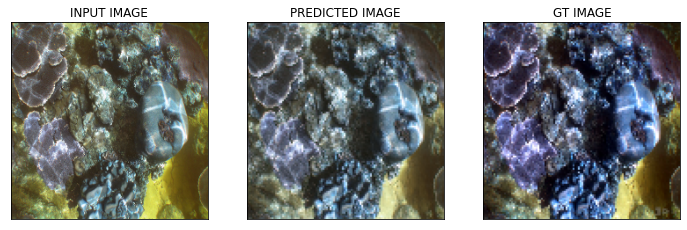

SSIM METRIC : 0.9047660292502034


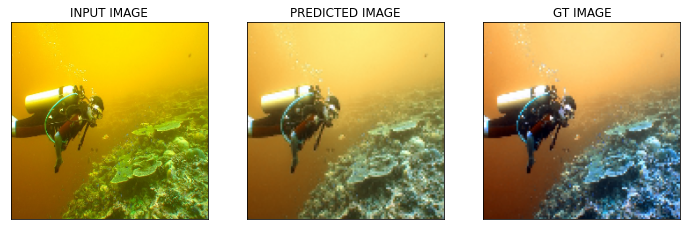

SSIM METRIC : 0.7083894071826684


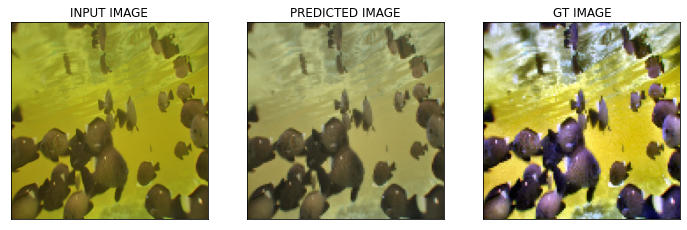

SSIM METRIC : 0.8838252302300699


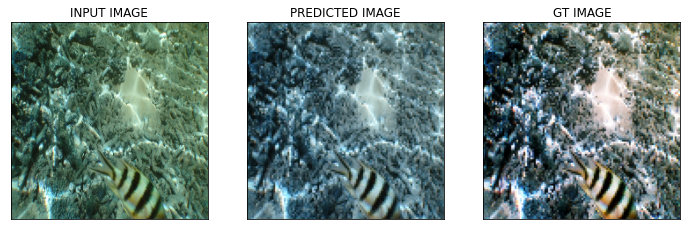

SSIM METRIC : 0.7710849005027183


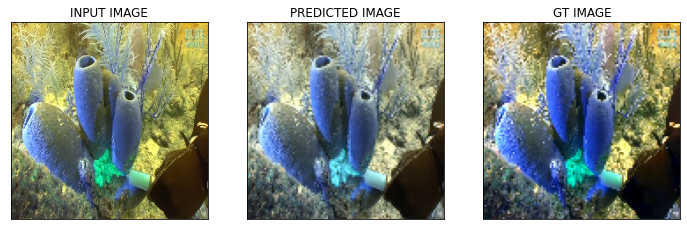

SSIM METRIC : 0.9257784089431622


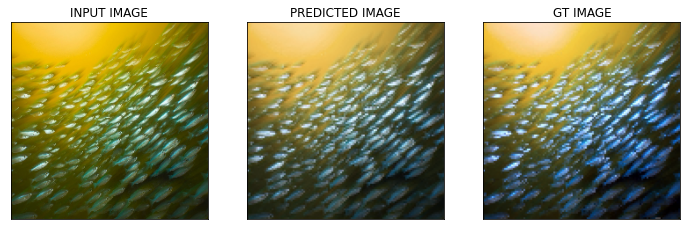

SSIM METRIC : 0.7319116449793238


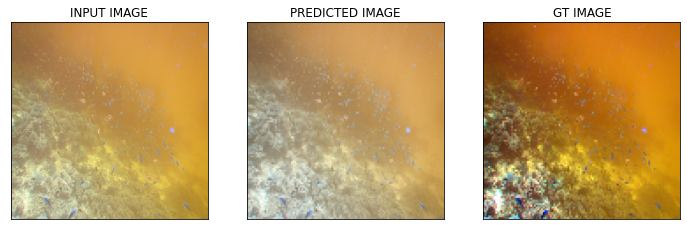

SSIM METRIC : 0.5001518812254014


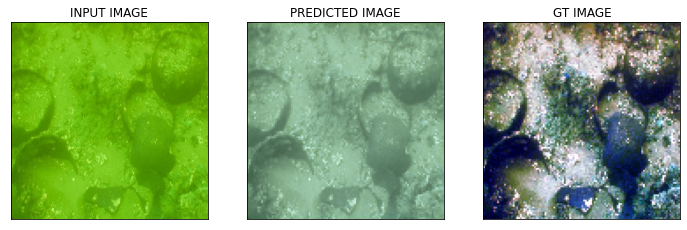

SSIM METRIC : 0.673925661225244


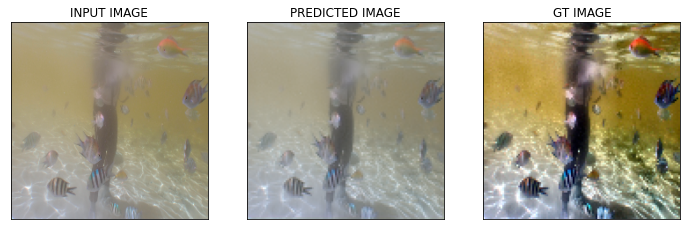

SSIM METRIC : 0.7490680036668982


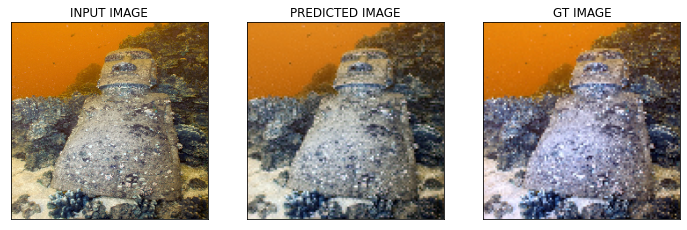

***********************************************
AVERAGE SSIM METRIC : 0.7737887503574898
***********************************************


In [ ]:
model.load_state_dict(T.load("./model.pth",map_location=T.device('cuda')))
model.eval()
ssim_t = []
for i in range(len(test_dataloader)):
    raw_normalized, enhanced = test_dataloader[i]
    raw,_ = test_dataloader.raw(i)
    y_pred = model(raw_normalized.unsqueeze(dim=0))
    raw = raw.permute(1,2,0).numpy()
    enhanced = enhanced.permute(1,2,0).numpy()
    y_pred = y_pred.squeeze(dim=0).permute(1,2,0).detach().cpu().numpy()
    a = evaluate(y_pred,enhanced)
    ssim_t.append(a)
    if i < 10:
        print("SSIM METRIC :",a)
        fig, ax = plt.subplots(1, 3,figsize=(12,4))
        ax[0].imshow(raw)        
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].title.set_text('INPUT IMAGE')
        ax[1].imshow(y_pred)        
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].title.set_text('PREDICTED IMAGE')
        ax[2].imshow(enhanced)        
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].title.set_text('GT IMAGE')
        plt.show()
print("***********************************************")
print("AVERAGE SSIM METRIC :",sum(ssim_t)/len(ssim_t))
print("***********************************************")